# **Application of machine learning for forecasting 3-month interest rate (3MUSD=) and USD FX level in Python**
Youssef Louraoui (20230348@etud.univ-evry.fr)

## **Preparation of the Working Environment on Python**

Below, we detail the essential Python packages that constitute the basis of the machine learning project.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
# The specific packages for running the machine learning models

from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv1D, MaxPooling1D, LSTM
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

In [5]:
# We start by importing the datasets from excel file

FX_data = pd.read_excel("/content/Data.xlsx", sheet_name="FX_extraction", skiprows=1)
Rates_data = pd.read_excel("/content/Data.xlsx", sheet_name="Rates_extraction", skiprows=1)
print(FX_data)
print(Rates_data)

     Unnamed: 0  GBP3MD=  EUR3MD=  USD3MD=  NOK3MD=  JPY3MD=  CHF3MD=  \
0    2014-01-01     0.45     0.20     0.16     1.54    -0.04    -0.10   
1    2014-01-02     0.45     0.20     0.19     1.54     0.01    -0.05   
2    2014-01-03     0.47     0.20     0.20     1.55     0.05    -0.10   
3    2014-01-06     0.48     0.20     0.21     1.53     0.01    -0.10   
4    2014-01-07     0.46     0.19     0.24     1.53     0.05    -0.10   
...         ...      ...      ...      ...      ...      ...      ...   
2632 2023-12-26     5.27     3.95     5.44     4.52    -0.51     1.58   
2633 2023-12-27     5.20     3.86     5.35     4.47    -0.55     1.58   
2634 2023-12-28     5.23     3.95     5.33     4.56    -0.30     1.44   
2635 2023-12-29     5.22     3.88     5.31     4.52    -0.28     1.58   
2636 2024-01-01     5.21     3.92     5.43     4.51    -0.28     1.58   

      AUD3MD=  NZD3MD=  CAD3MD=  SEK3MD=  
0        2.55     2.70     0.92     0.82  
1        2.56     2.82     1.07     0

In [6]:
# Rename the first column to 'Date' in both dataframes
FX_data.rename(columns={FX_data.columns[0]: 'Date'}, inplace=True)
Rates_data.rename(columns={Rates_data.columns[0]: 'Date'}, inplace=True)

# We convert the 'Date' columns to datetime
FX_data['Date'] = pd.to_datetime(FX_data['Date'])
Rates_data['Date'] = pd.to_datetime(Rates_data['Date'])

# First merge: Merge FX_data and Rates_data on 'Date'
merged_df = pd.merge(FX_data, Rates_data, on='Date', how='outer')

# Removing rows with any NA values
merged_df.dropna(inplace=True)

# Ensuring all columns except 'Date' are numeric
numeric_cols = merged_df.select_dtypes(include=[float, int]).columns
merged_df[numeric_cols] = merged_df[numeric_cols].apply(pd.to_numeric, errors='coerce')

# We set the 'Date' column as the index
merged_df.set_index('Date', inplace=True)

In [73]:
# Eliminate the columns that will not be used
columns_to_remove = ['Date','USD3MD=']
predictor_columns = [col for col in merged_df.columns if col not in columns_to_remove]

# Isolate the forecasted data into a separate DataFrame
df_variables = merged_df[predictor_columns]
df_USD3M = merged_df[['USD3MD=']].copy()
df_USDfx = merged_df[['=USD']].copy()

# Have a look at the different variables that are used as predictors for the analysis
print(df_variables.info())
print(df_variables.describe())
print(df_variables.head())
print(df_USD3M.head())
print(df_USDfx.head())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2608 entries, 2014-01-02 to 2024-01-01
Data columns (total 19 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   GBP3MD=  2608 non-null   float64
 1   EUR3MD=  2608 non-null   float64
 2   NOK3MD=  2608 non-null   float64
 3   JPY3MD=  2608 non-null   float64
 4   CHF3MD=  2608 non-null   float64
 5   AUD3MD=  2608 non-null   float64
 6   NZD3MD=  2608 non-null   float64
 7   CAD3MD=  2608 non-null   float64
 8   SEK3MD=  2608 non-null   float64
 9   GBP=     2608 non-null   float64
 10  EUR=     2608 non-null   float64
 11  =USD     2608 non-null   float64
 12  NOK=     2608 non-null   float64
 13  JPY=     2608 non-null   float64
 14  CHF=     2608 non-null   float64
 15  AUD=     2608 non-null   float64
 16  NZD=     2608 non-null   float64
 17  CAD=     2608 non-null   float64
 18  SEK=     2608 non-null   float64
dtypes: float64(19)
memory usage: 407.5 KB
None
           GBP3MD=      EUR3M

In [19]:
# Analysis of the data from the 3-month interest rate patterns
print(df_USD3M.info())
print(df_USD3M.describe())
print(df_USD3M.head())

# Calculate returns for the predictors
arith_returns = df_variables.pct_change().dropna()

# Analysis of the statistical performance of the 3-month interest rate loading
print(df_USD3M['USD3MD='].pct_change().dropna().head())
print(df_USD3M['USD3MD='].pct_change().dropna().describe())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2608 entries, 2014-01-02 to 2024-01-01
Data columns (total 1 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   USD3MD=  2608 non-null   float64
dtypes: float64(1)
memory usage: 40.8 KB
None
           USD3MD=
count  2608.000000
mean      1.534456
std       1.612131
min       0.050000
25%       0.230000
50%       0.960000
75%       2.290000
max       5.740000
            USD3MD=
Date               
2014-01-02     0.19
2014-01-03     0.20
2014-01-06     0.21
2014-01-07     0.24
2014-01-08     0.17
Date
2014-01-03    0.052632
2014-01-06    0.050000
2014-01-07    0.142857
2014-01-08   -0.291667
2014-01-09   -0.058824
Name: USD3MD=, dtype: float64
count    2607.000000
mean        0.020883
std         0.250490
min        -0.812500
25%        -0.003636
50%         0.000000
75%         0.007775
max         4.333333
Name: USD3MD=, dtype: float64


In [20]:
from scipy import stats
# Standardize the data
df_variables_standardized = (df_variables - df_variables.mean()) / df_variables.std()

# Remove outliers beyond 3 standard deviations
df_variables_zscore = df_variables_standardized[(np.abs(stats.zscore(df_variables_standardized)) < 3).all(axis=1)]

<Figure size 1600x1200 with 0 Axes>

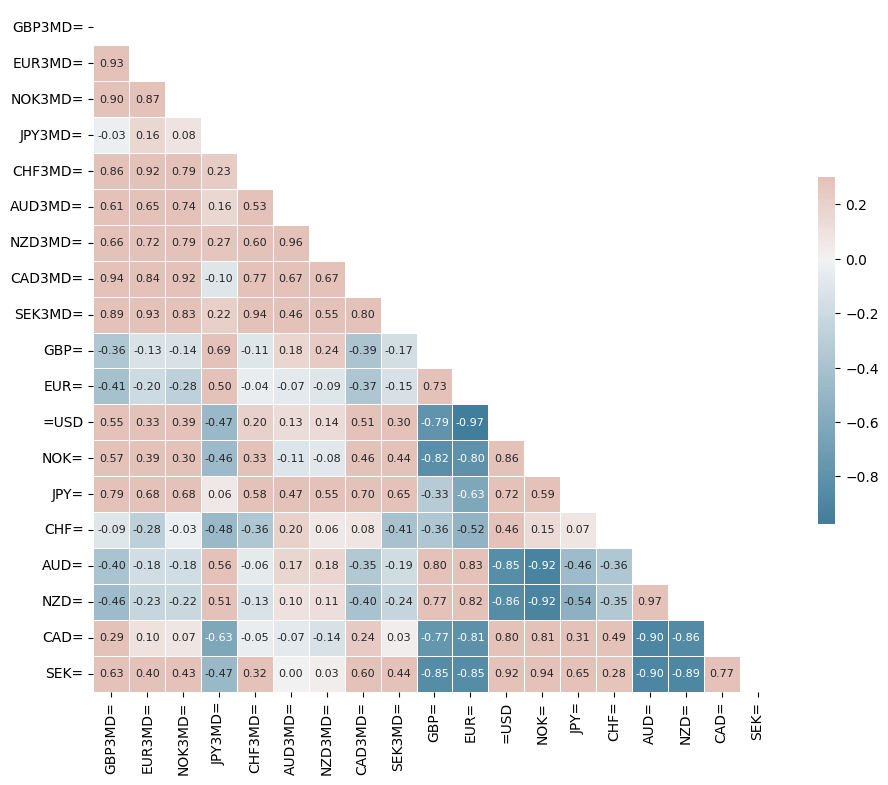

In [137]:
import seaborn as sns

correlation_matrix = df_variables_zscore.corr()

# Using seaborn to create a heatmap of the correlation matrix
plt.figure(figsize=(16, 12))

# Generate a mask for the upper triangle.
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))

# Set up the matplotlib figure.
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap.
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio.
sns.heatmap(correlation_matrix, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5},
            annot=True, fmt=".2f", annot_kws={"size": 8})

# Adjust the font size of the tick labels for clarity.
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

plt.show()

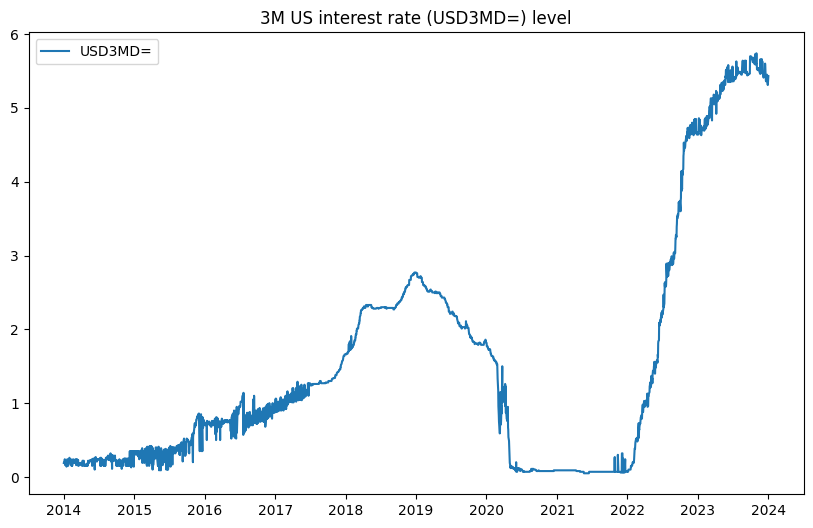

In [140]:
# Plot the 3M US interest rate time series
plt.figure(figsize=(10, 6))
plt.plot(df_USD3M['USD3MD='], label='USD3MD=')
plt.title('3M US interest rate (USD3MD=) level')
plt.legend()
plt.show()

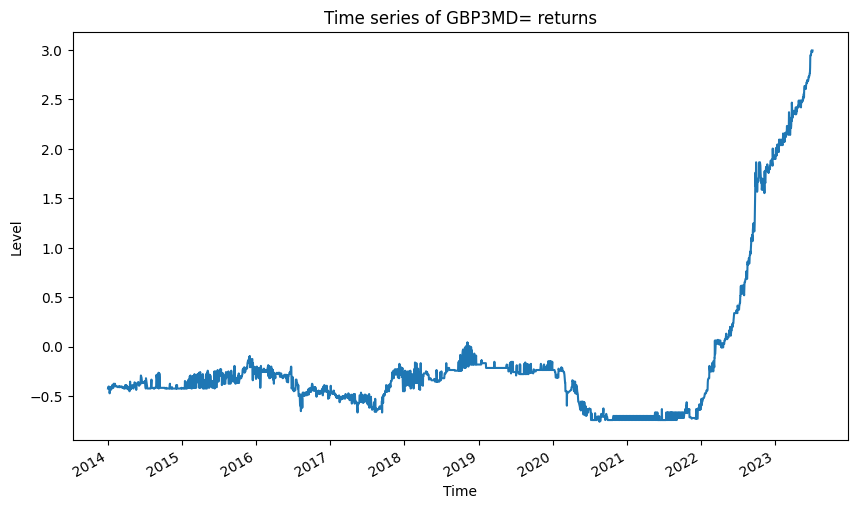

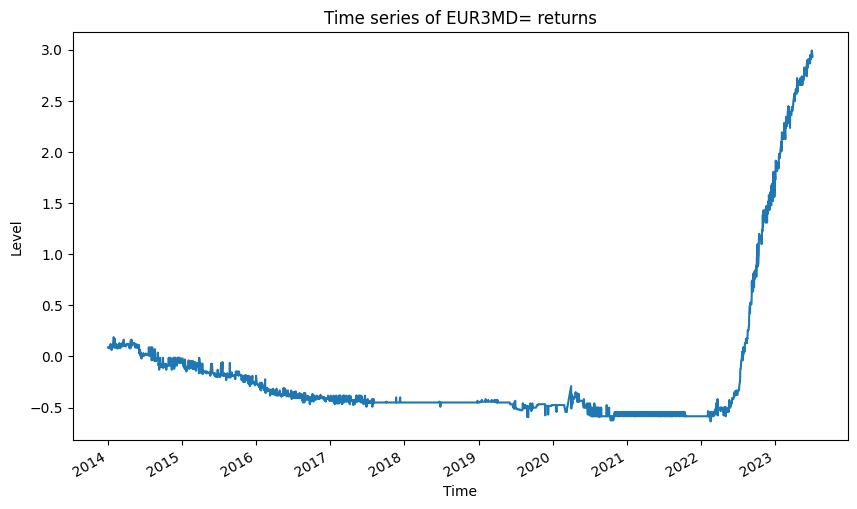

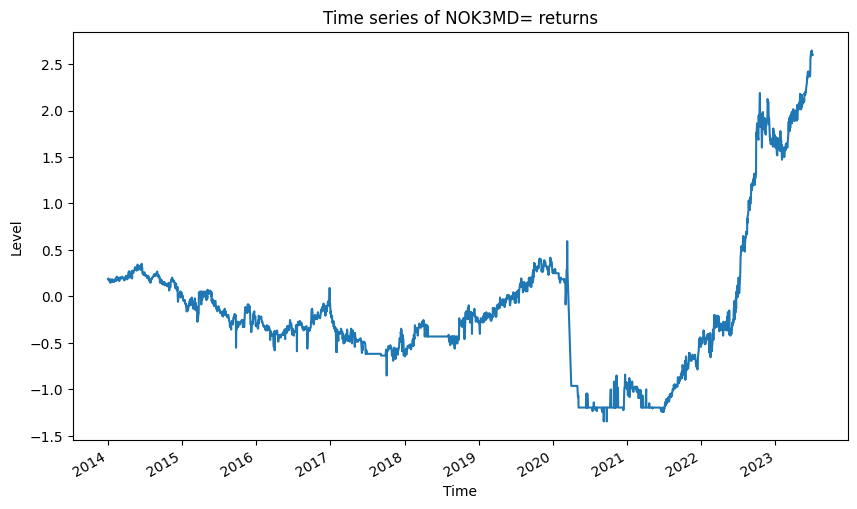

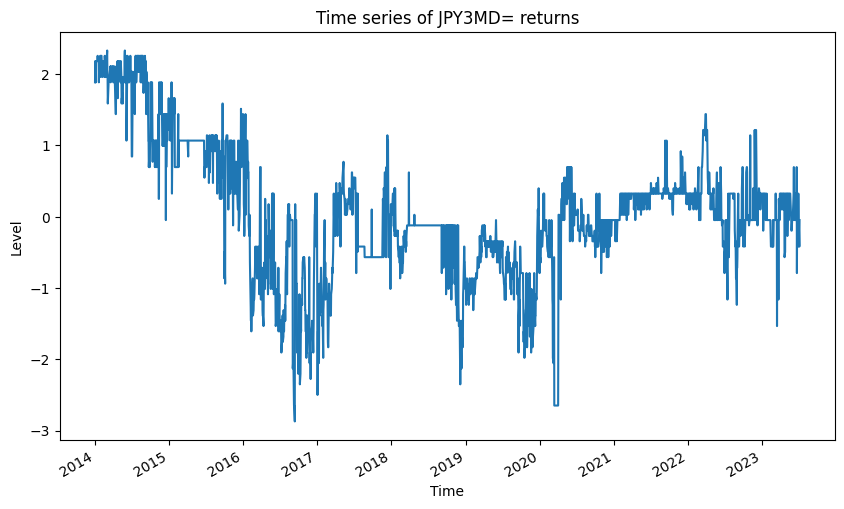

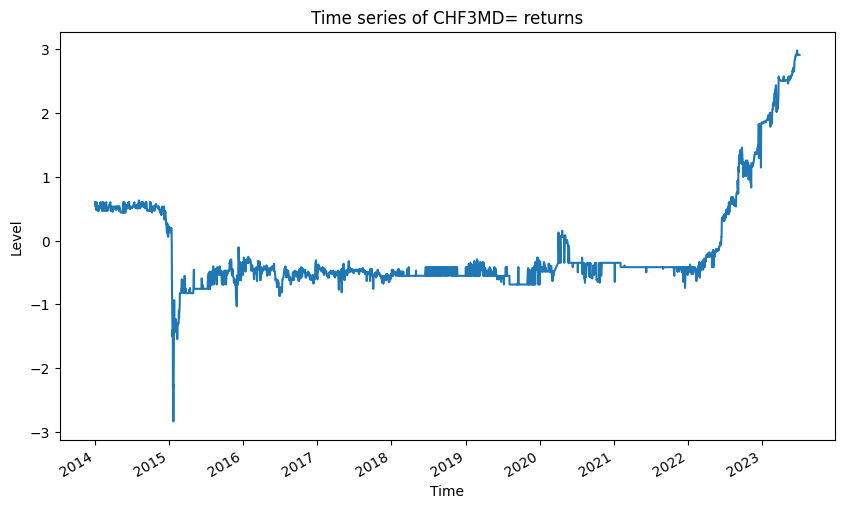

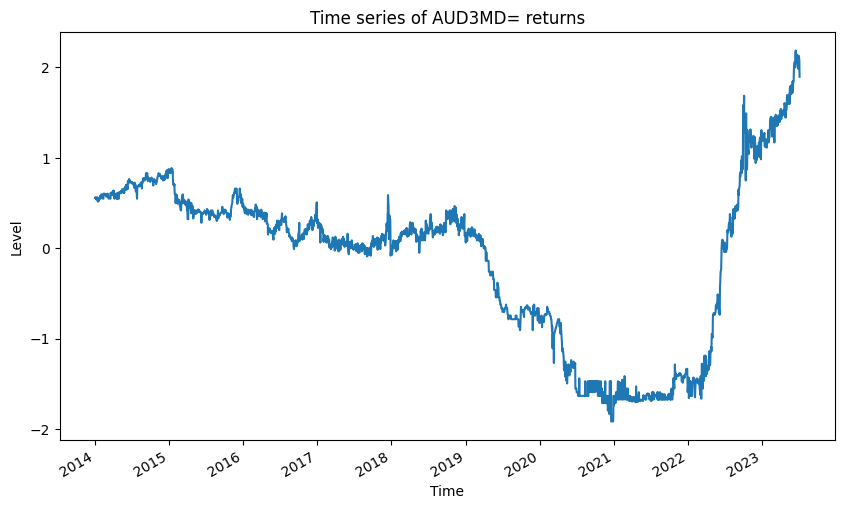

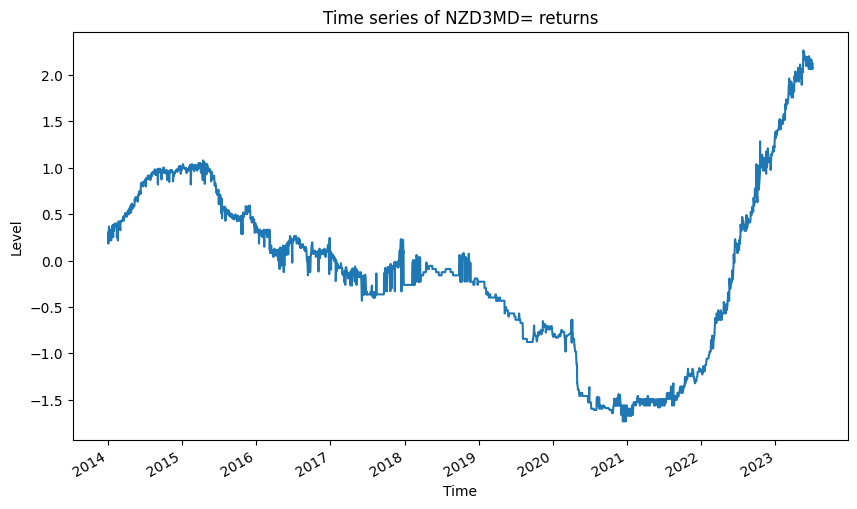

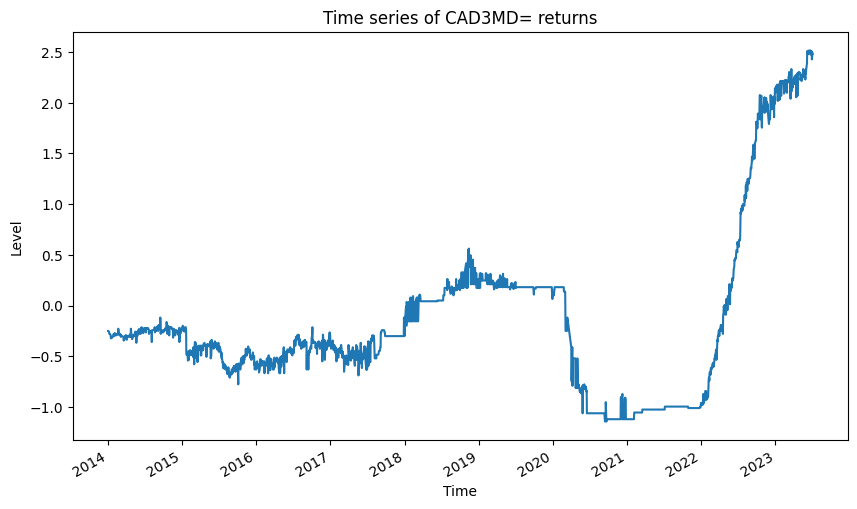

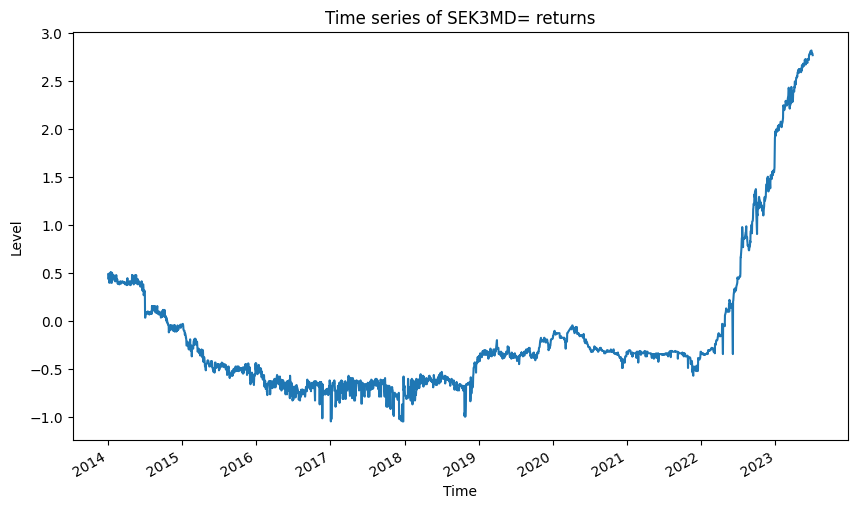

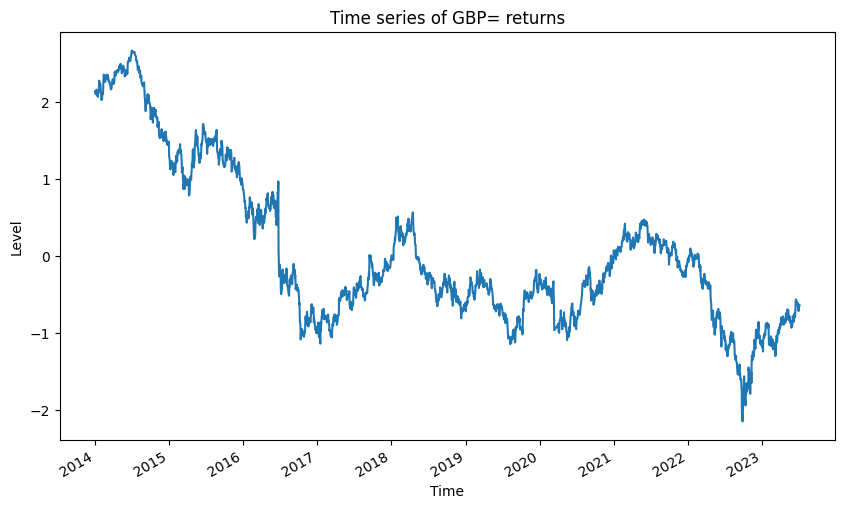

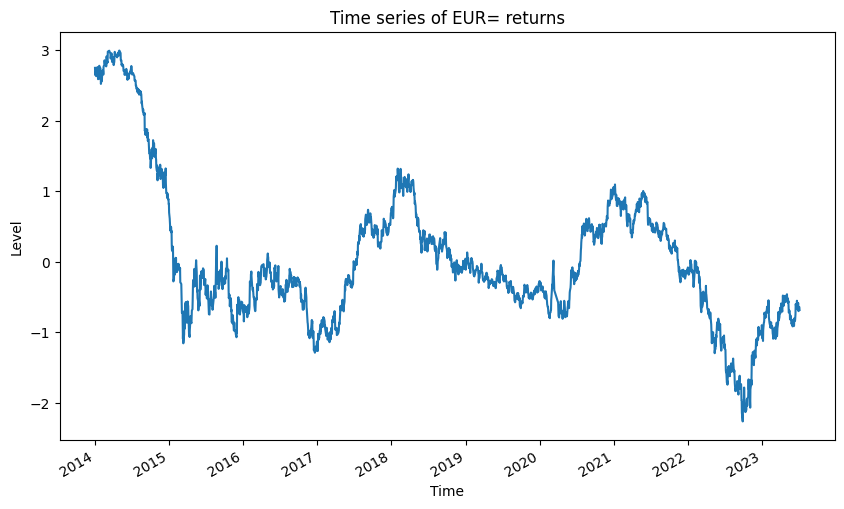

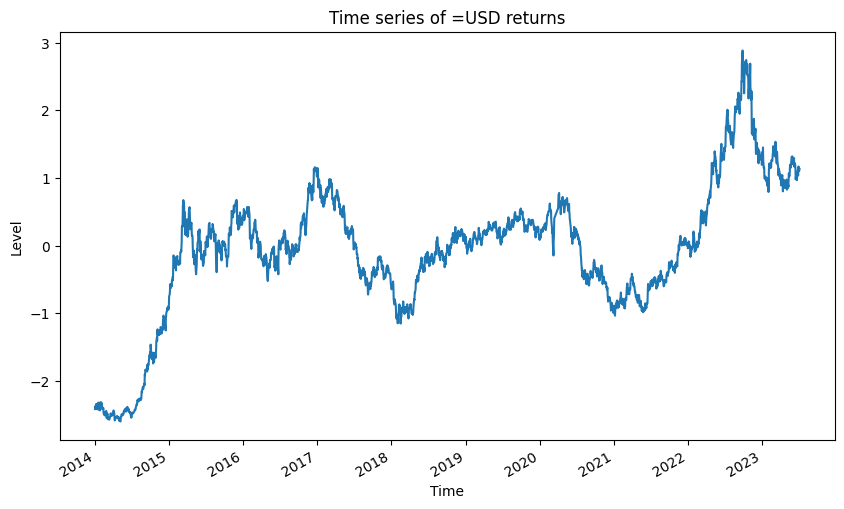

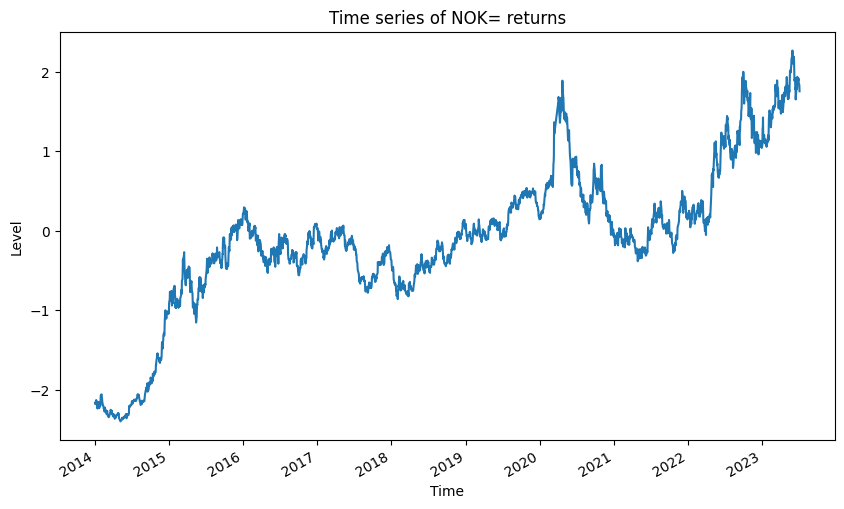

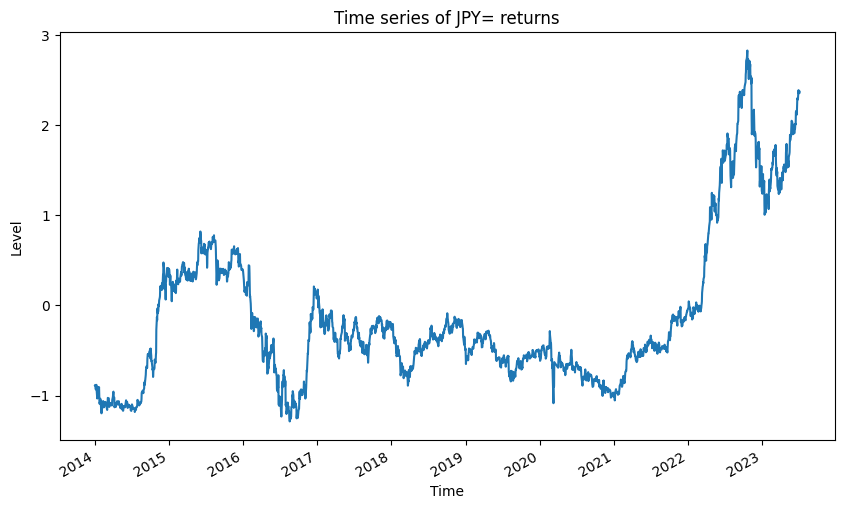

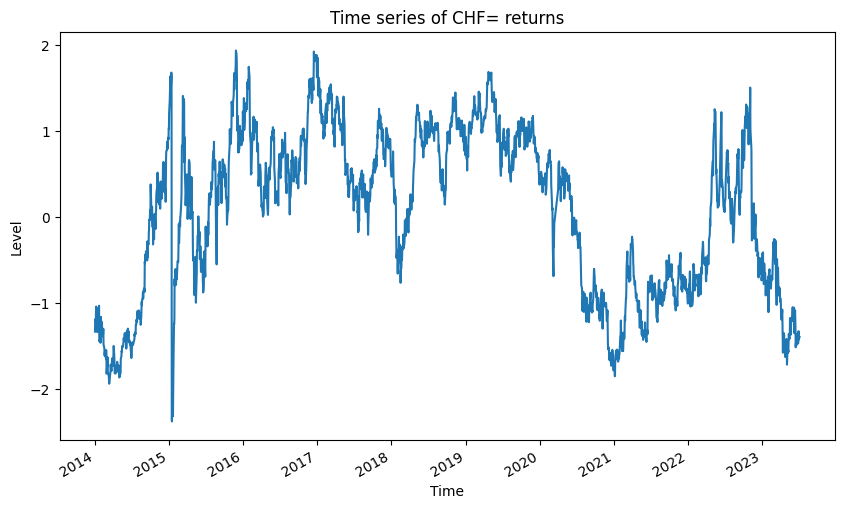

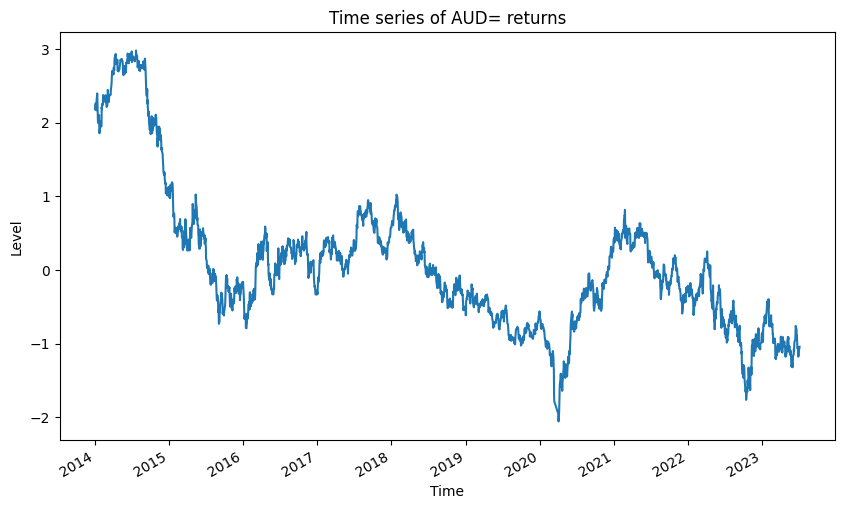

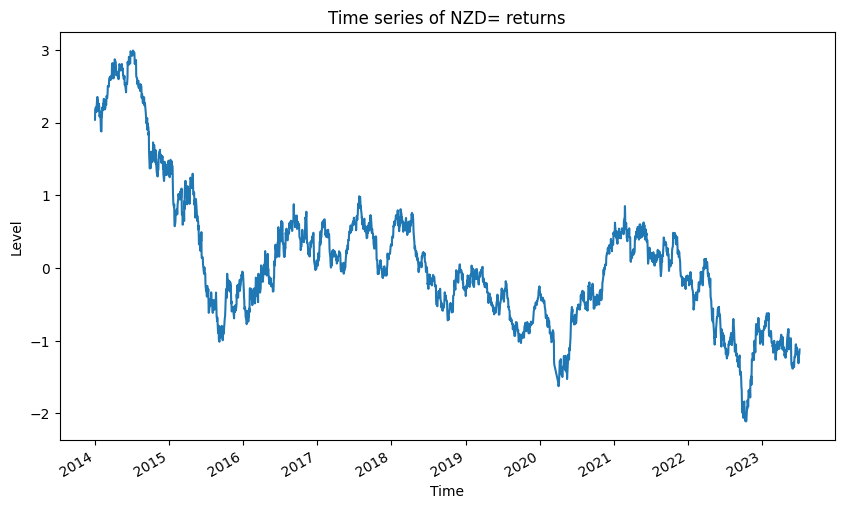

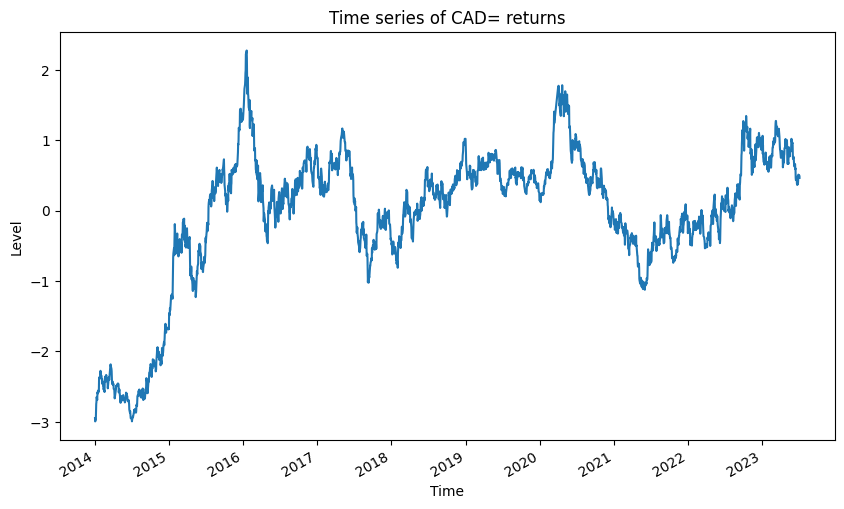

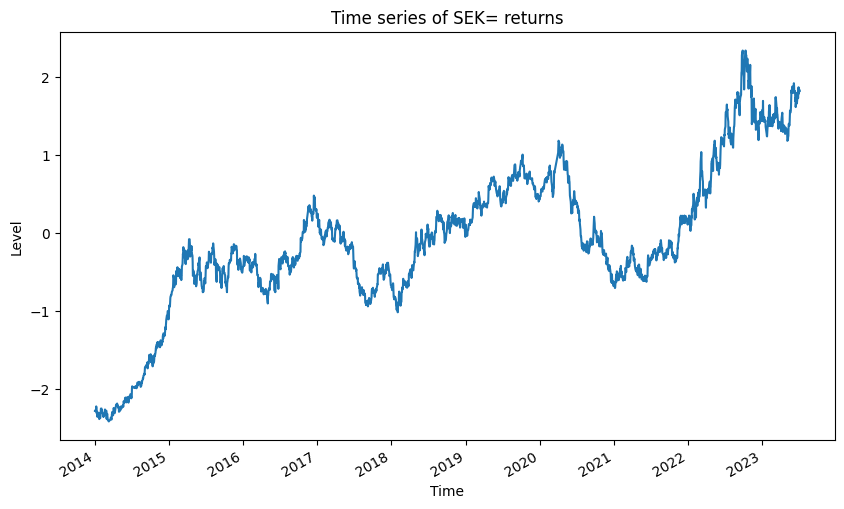

In [65]:
# Loop through each column in the arith_returns DataFrame
for column in df_variables_zscore:
    # Plot the histogram for each column
    plt.figure(figsize=(10, 6))
    df_variables_zscore[column].plot(title=f"Time series of {column}")
    plt.title(f"Time series of {column} returns")
    plt.xlabel("Time")
    plt.ylabel("Level")
    plt.show()

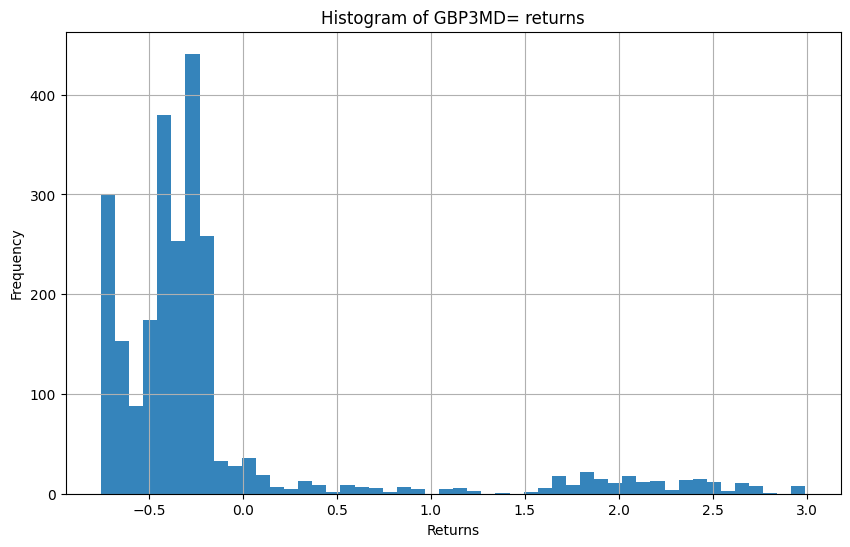

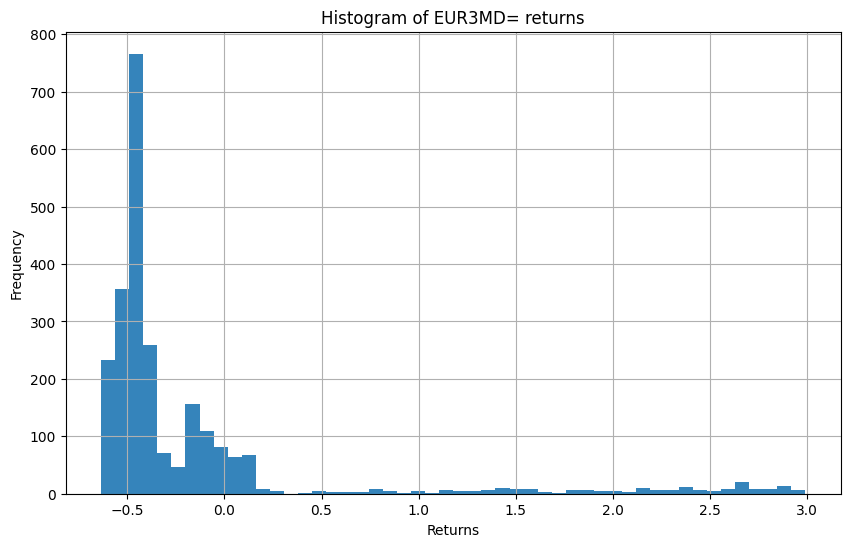

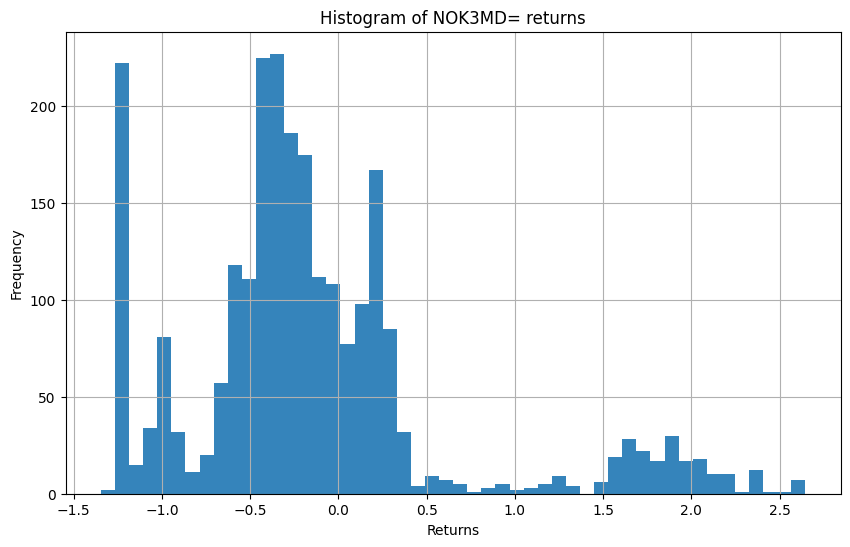

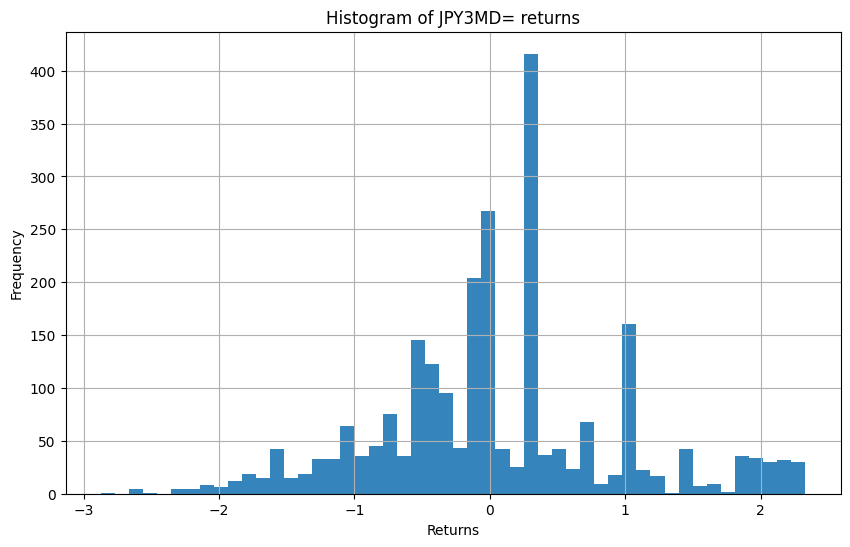

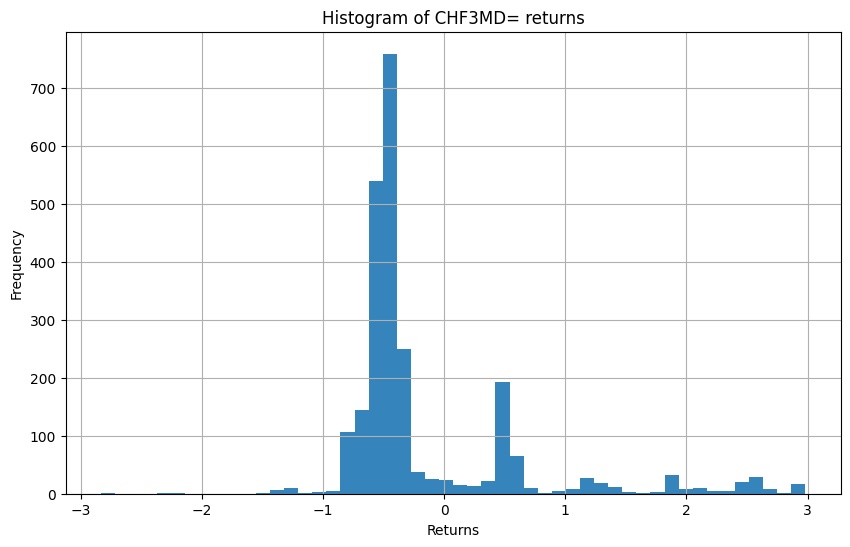

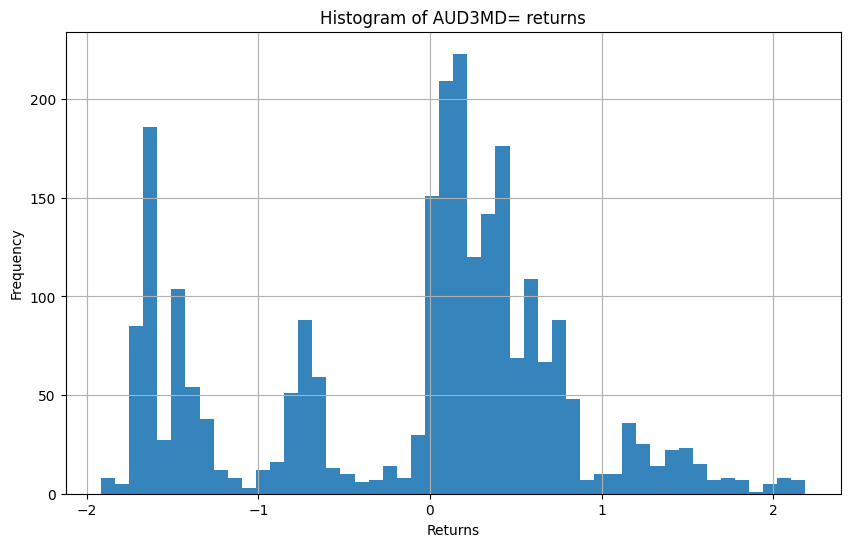

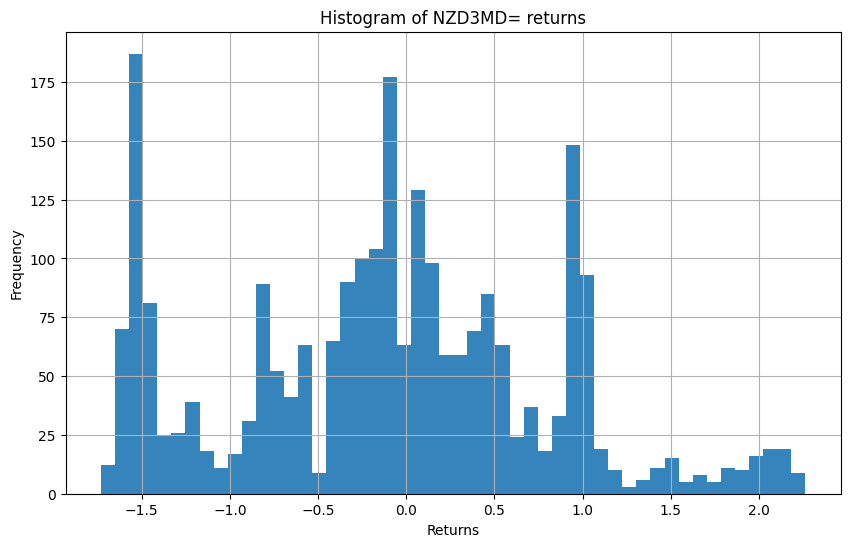

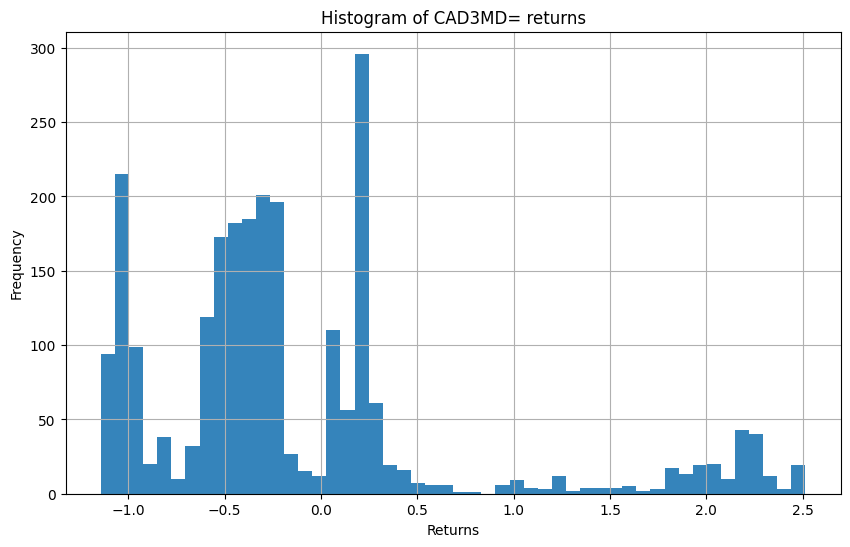

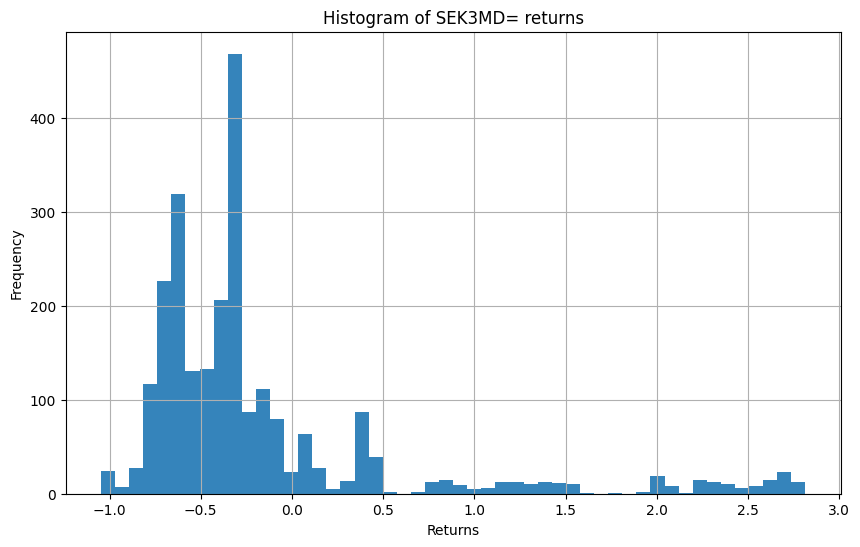

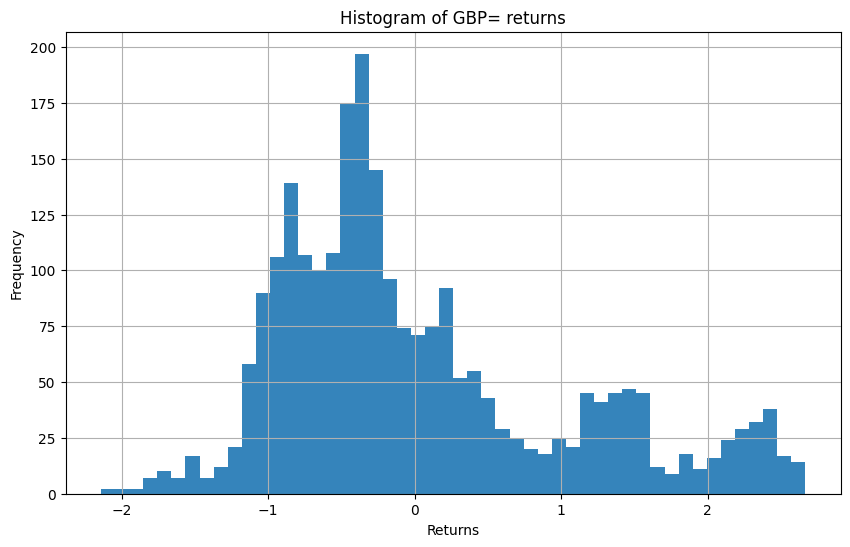

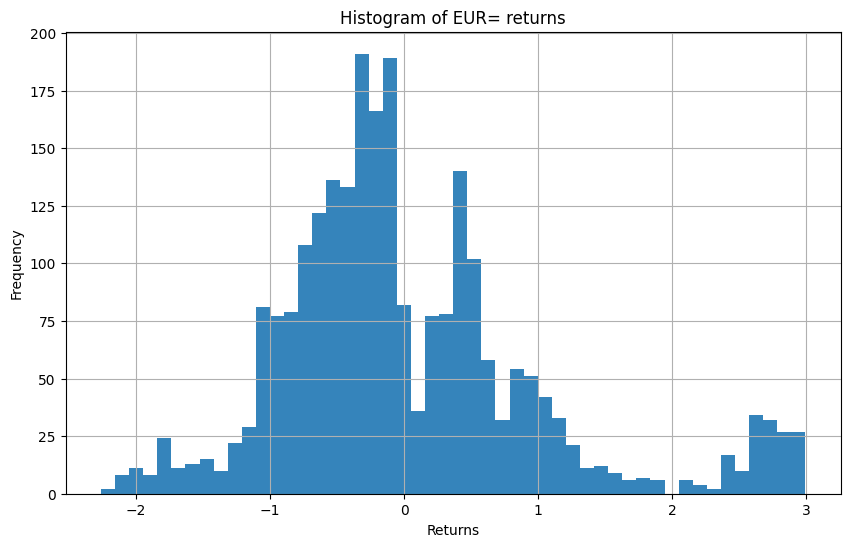

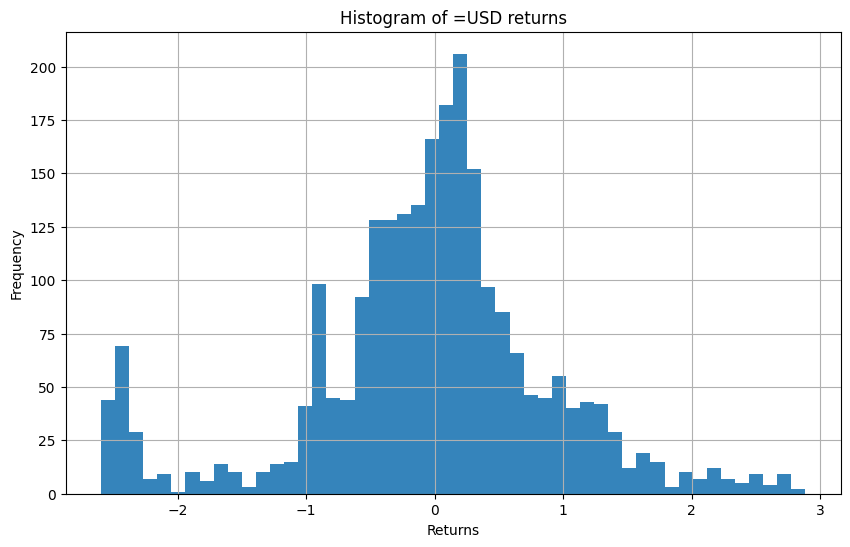

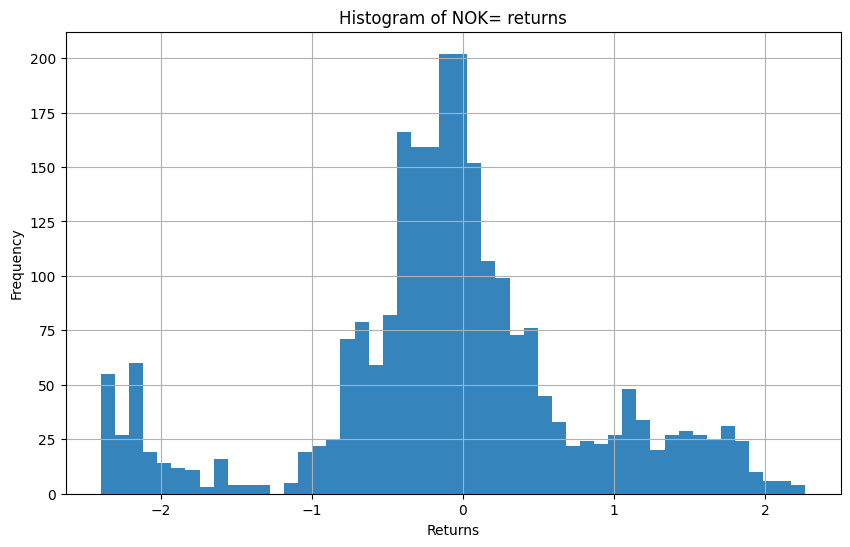

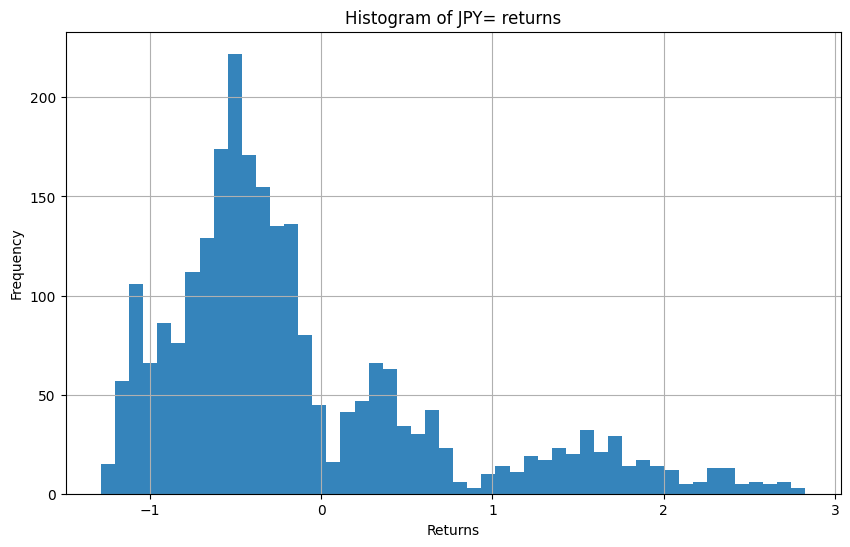

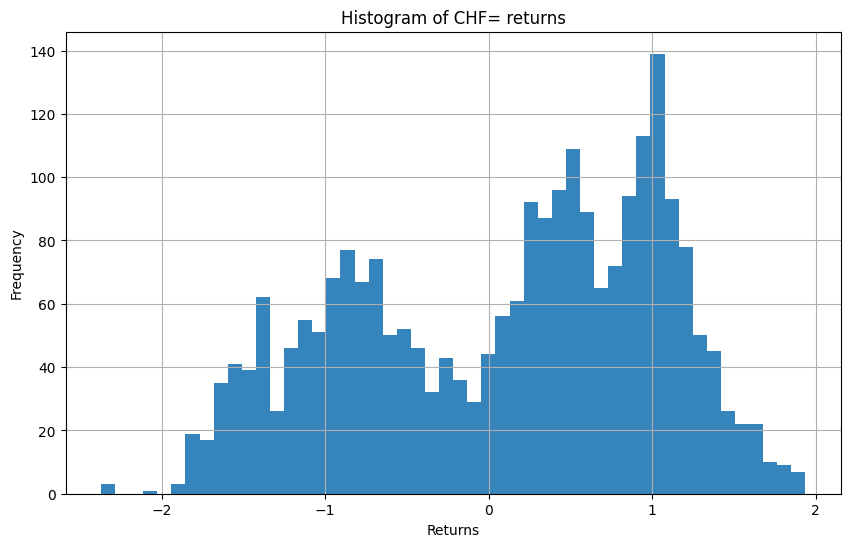

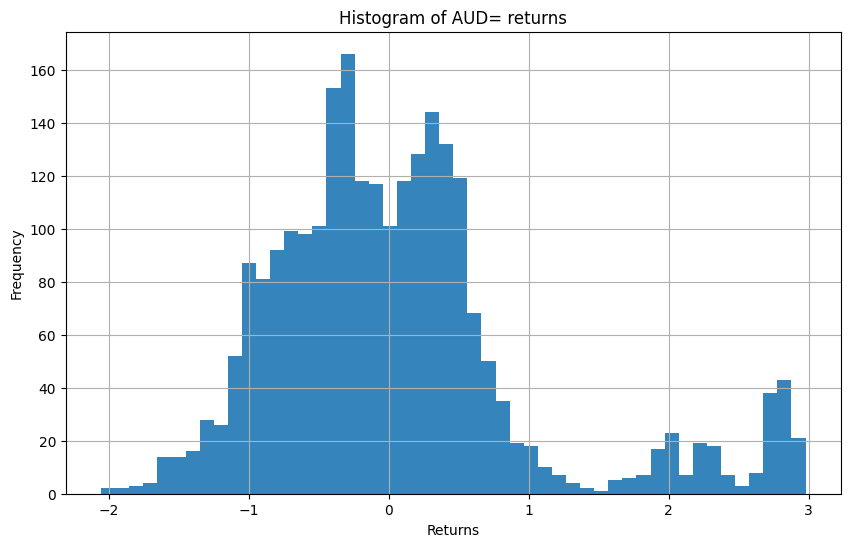

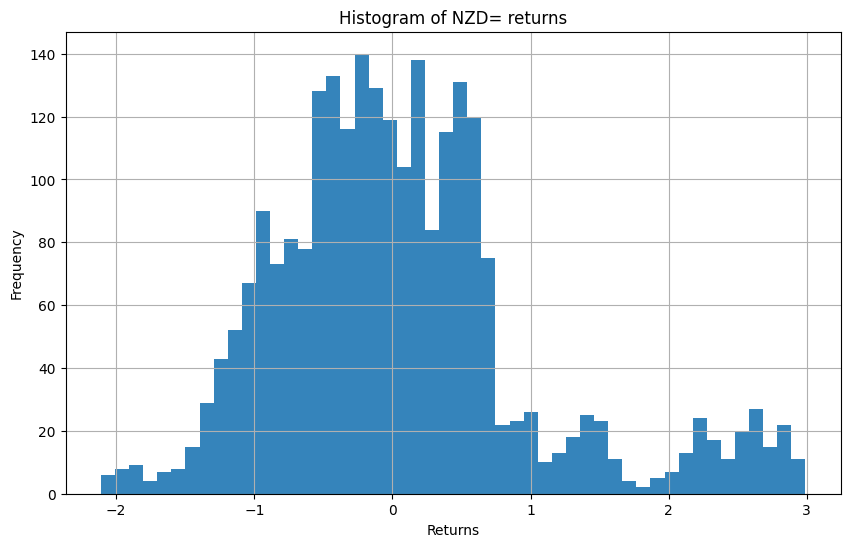

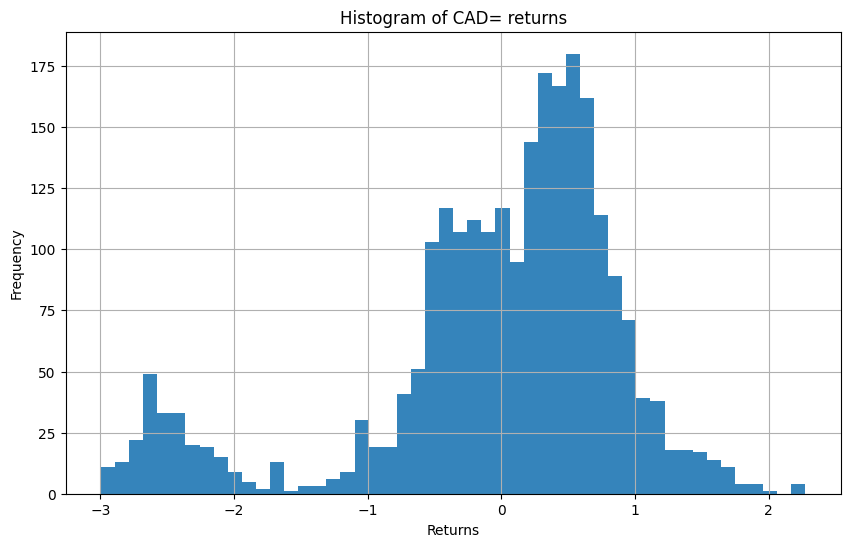

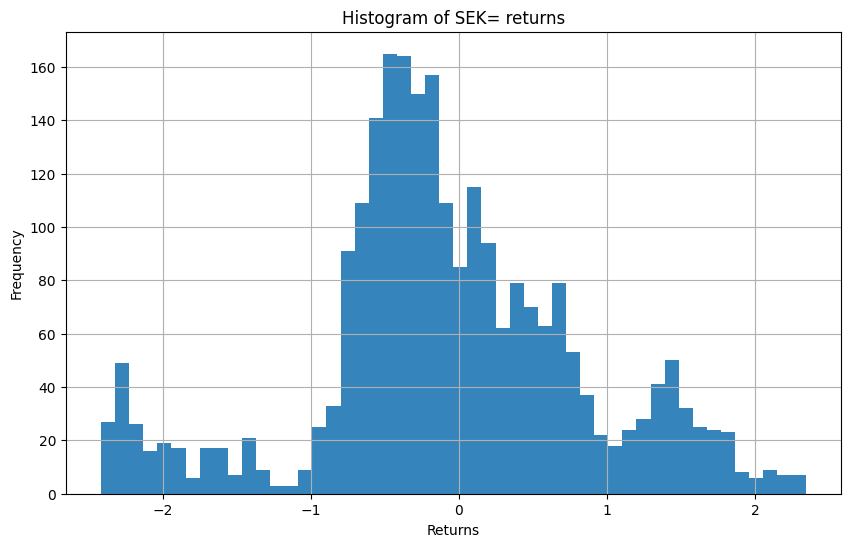

In [117]:
# Loop through each column in the arith_returns DataFrame
for column in df_variables_zscore:
    # Plot the histogram for each column
    plt.figure(figsize=(10, 6))
    df_variables_zscore[column].hist(bins=50, alpha=0.9)
    plt.title(f"Histogram of {column} returns")
    plt.xlabel("Returns")
    plt.ylabel("Frequency")
    plt.show()

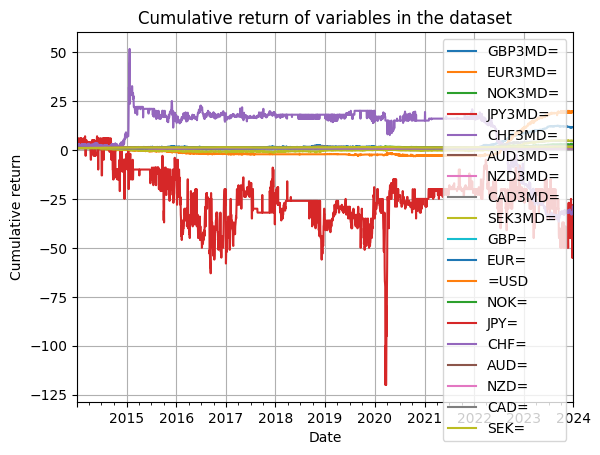

In [26]:
# Calculation of the cumulative returns for the variables index

cumulative_return_variables = (1 + arith_returns).cumprod()

cumulative_return_variables.plot(title=f"Cumulative return of variables in the dataset")
plt.xlabel("Date")
plt.ylabel("Cumulative return")
plt.grid(True)
plt.show()

In [169]:
# Scaling of the dataset to better handle the modeling of the machine learning programs

scaler = MinMaxScaler()
x = df_variables
y_fx = df_USDfx
y_USD = df_USD3M

#Change the y_xxx depending on which variable to assess (y_fx to train USD index forecasting and y_USD to train 3M US interest rate forecasting)

# Split the dataset into training and testing sets without shuffling to preserve time series order (change either y_fx or y_USD)
X_train_df, X_test_df, Y_train_df, Y_test_df = train_test_split(df_variables, y_USD, train_size=0.7, shuffle=False)

# Convert the DataFrames to NumPy arrays for use in the neural network
X_train, X_test, Y_train, Y_test = X_train_df.to_numpy(), X_test_df.to_numpy(), Y_train_df.to_numpy(), Y_test_df.to_numpy()

# Initialize the MinMaxScaler
scaler = MinMaxScaler()

# Scale the training data
training_values = scaler.fit_transform(Y_train)

## **1. Implementation of MLP and LSTM models on 3-month US interest rate (USD3MD=) and USD (=USD) index data**

### 1.1 Deconstruction of the training sets

In [143]:
'''
#Data manipulation for the USD index
df_train_fx = df_USDfx[df_USDfx.index < Y_test_df.index[0]]
df_test_fx = df_USDfx[df_USDfx.index >= Y_test_df.index[0]]

train_fx = df_train_fx['=USD'].values
test_fx = df_test_fx['=USD'].values
'''

#Data manipulation for the 3M USD interest rate
df_train_USD3M = df_USD3M[df_USD3M.index < Y_test_df.index[0]]
df_test_USD3M = df_USD3M[df_USD3M.index >= Y_test_df.index[0]]

train_USD3M = df_train_USD3M['USD3MD='].values
test_USD3M = df_test_USD3M['USD3MD='].values


training_values = scaler.fit_transform(train_USD3M.reshape(-1, 1))

x_train = training_values[0:len(training_values)-1000]
y_train = training_values[1000:len(training_values)]

test_values = scaler.transform(test_USD3M.reshape(-1, 1))

#Adjust the script accordingly to match the model purpose (forecasting of USD index levels or 3M US interest rate)

### 1.2 Implementation of an MLP model

In [144]:
# MLP model structure

model_MLP_USD = Sequential()
model_MLP_USD.add(Dense(2048, activation='relu'))
model_MLP_USD.add(Dense(512, activation='relu'))
model_MLP_USD.add(Dense(128, activation='relu'))
model_MLP_USD.add(Dropout(0.25))
model_MLP_USD.add(Dense(32, activation='relu'))
model_MLP_USD.add(Dense(8, activation='relu'))
model_MLP_USD.add(Dense(4, activation='relu'))
model_MLP_USD.add(Dense(1))

In [145]:
# Parametrization of the MLP model (optimizer, loss type)

model_MLP_USD.compile(loss='mean_squared_error', optimizer='adam')

In [146]:
# Calibration of the MLP model parameters

model_MLP_USD.fit(x_train, y_train, epochs=10, batch_size=16)

Epoch 1/10
52/52 [==============================] - 7s 108ms/step - loss: 0.1283
Epoch 2/10
52/52 [==============================] - 3s 56ms/step - loss: 0.0476
Epoch 3/10
52/52 [==============================] - 1s 17ms/step - loss: 0.0402
Epoch 4/10
52/52 [==============================] - 3s 58ms/step - loss: 0.0440
Epoch 5/10
52/52 [==============================] - 3s 56ms/step - loss: 0.0376
Epoch 6/10
52/52 [==============================] - 7s 136ms/step - loss: 0.0380
Epoch 7/10
52/52 [==============================] - 3s 62ms/step - loss: 0.0405
Epoch 8/10
52/52 [==============================] - 3s 57ms/step - loss: 0.0378
Epoch 9/10
52/52 [==============================] - 3s 56ms/step - loss: 0.0387
Epoch 10/10
52/52 [==============================] - 3s 66ms/step - loss: 0.0375


In [147]:
# We perform a prediction of the model for the USD3MD= loading

price_MLP_USD = model_MLP_USD.predict(test_values)
price_MLP_USD = scaler.inverse_transform(price_MLP_USD)
price_MLP_USD = np.squeeze(price_MLP_USD.reshape(1,-1))
price_MLP_USD

25/25 [==============================] - 0s 7ms/step


array([ 2.17694998e+00,  2.17694998e+00,  2.17694998e+00,  2.17694998e+00,
        2.17694998e+00,  2.17694998e+00,  2.17694998e+00,  2.17694998e+00,
        2.17694998e+00,  2.17694998e+00,  2.17694998e+00,  2.17694998e+00,
        2.17694998e+00,  2.17694998e+00,  2.17694998e+00,  2.17694998e+00,
        2.17694998e+00,  2.17694998e+00,  2.17694998e+00,  2.17694998e+00,
        2.17694998e+00,  2.17694998e+00,  2.17694998e+00,  2.17694998e+00,
        2.17694998e+00,  2.17694998e+00,  2.17694998e+00,  2.17694998e+00,
        2.17694998e+00,  2.17694998e+00,  2.17694998e+00,  2.17694998e+00,
        2.17694998e+00,  2.17694998e+00,  2.17694998e+00,  2.17694998e+00,
        2.17694998e+00,  2.17694998e+00,  2.17694998e+00,  2.17694998e+00,
        2.17694998e+00,  2.17694998e+00,  2.17694998e+00,  2.17694998e+00,
        2.17694998e+00,  2.17694998e+00,  2.17694998e+00,  2.17694998e+00,
        2.17694998e+00,  2.17694998e+00,  2.17694998e+00,  2.17694998e+00,
        2.17694998e+00,  

### 1.3 Implementation of the LSTM model

In [148]:
#Implementation of LSTM model

model_LSTM_USD = Sequential()
model_LSTM_USD.add(LSTM(128, return_sequences=True, input_shape=(None,1)))
model_LSTM_USD.add(LSTM(64, return_sequences=False))
model_LSTM_USD.add(Dropout(0.25))
model_LSTM_USD.add(Dense(25, activation='relu'))
model_LSTM_USD.add(Dense(1))

In [149]:
# We arrange the parameters (optimizer, loss)
model_LSTM_USD.compile(optimizer='adam', loss='mean_squared_error')

In [150]:
# Calibration of LSTM
model_LSTM_USD.fit(x_train, y_train,epochs=10, batch_size=16)

Epoch 1/10
52/52 [==============================] - 5s 19ms/step - loss: 0.2742
Epoch 2/10
52/52 [==============================] - 0s 5ms/step - loss: 0.1145
Epoch 3/10
52/52 [==============================] - 0s 6ms/step - loss: 0.0840
Epoch 4/10
52/52 [==============================] - 2s 46ms/step - loss: 0.0525
Epoch 5/10
52/52 [==============================] - 0s 5ms/step - loss: 0.0469
Epoch 6/10
52/52 [==============================] - 0s 5ms/step - loss: 0.0446
Epoch 7/10
52/52 [==============================] - 3s 55ms/step - loss: 0.0448
Epoch 8/10
52/52 [==============================] - 0s 8ms/step - loss: 0.0425
Epoch 9/10
52/52 [==============================] - 2s 48ms/step - loss: 0.0441
Epoch 10/10
52/52 [==============================] - 0s 6ms/step - loss: 0.0435


In [151]:
# Predictions for LSTM

price_LSTM_USD = model_LSTM_USD.predict(test_values)
price_LSTM_USD = scaler.inverse_transform(price_LSTM_USD)
price_LSTM_USD = np.squeeze(price_LSTM_USD)
price_LSTM_USD

25/25 [==============================] - 1s 3ms/step


array([ 2.4989967 ,  2.4989967 ,  2.4989967 ,  2.4989967 ,  2.4989967 ,
        2.4989967 ,  2.4989967 ,  2.4989967 ,  2.4989967 ,  2.4989967 ,
        2.4989967 ,  2.4989967 ,  2.4989967 ,  2.4989967 ,  2.4989967 ,
        2.4989967 ,  2.4989967 ,  2.4989967 ,  2.4989967 ,  2.4989967 ,
        2.4989967 ,  2.4989967 ,  2.4989967 ,  2.4989967 ,  2.4989967 ,
        2.4989967 ,  2.4989967 ,  2.4989967 ,  2.4989967 ,  2.4989967 ,
        2.4989967 ,  2.4989967 ,  2.4989967 ,  2.4989967 ,  2.4989967 ,
        2.4989967 ,  2.4989967 ,  2.4989967 ,  2.4989967 ,  2.4989967 ,
        2.4989967 ,  2.4989967 ,  2.4989967 ,  2.4989967 ,  2.4989967 ,
        2.4989967 ,  2.4989967 ,  2.4989967 ,  2.4989967 ,  2.4989967 ,
        2.4989967 ,  2.4989967 ,  2.4989967 ,  2.4989967 ,  2.4989967 ,
        2.4989967 ,  2.4989967 ,  2.4989967 ,  2.4989967 ,  2.4989967 ,
        2.4989967 ,  2.4989967 ,  2.4989967 ,  2.4989967 ,  2.4989967 ,
        2.4989967 ,  2.4989967 ,  2.4989967 ,  2.4989967 ,  2.49

In [152]:
# Ensure Y_test is 1-dimensional
Y_test = Y_test.reshape(-1)

# Ensure predictions are 1-dimensional
price_MLP_USD = np.squeeze(price_MLP_USD)
price_LSTM_USD = np.squeeze(price_LSTM_USD)

# Results of the implemented models in a dataframe
results_USD_prediction = pd.DataFrame({
    'Real_price_USD': Y_test,
    'Pred_MLP_USD': price_MLP_USD,
    'Pred_LSTM_USD': price_LSTM_USD
})

<Axes: >

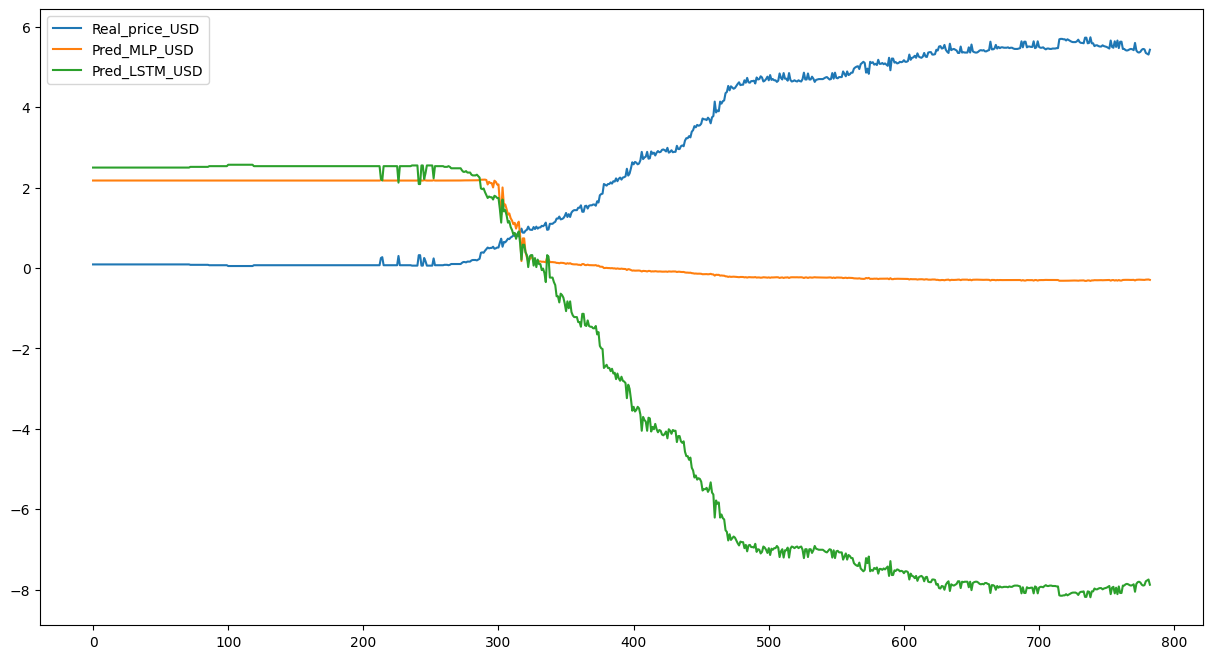

In [153]:
# Plotting the predictions against actual USD3MD= prices for MLP and LSTM

results_USD_prediction['Real_price_USD'].plot(legend='Real level of USD3MD=', figsize=(15,8))
results_USD_prediction['Pred_MLP_USD'].plot(legend='Forecast MLP')
results_USD_prediction['Pred_LSTM_USD'].plot(legend='Forecast LSTM')

In [154]:
# Computation of the mean absolut error (MAE):

MAE_pred_MLP_USD = mean_absolute_error(results_USD_prediction['Real_price_USD'], results_USD_prediction['Pred_MLP_USD'])
MAE_pred_LSTM_USD = mean_absolute_error(results_USD_prediction['Real_price_USD'], results_USD_prediction['Pred_LSTM_USD'])
print("MAE for the forecasted MLP model:", MAE_pred_MLP_USD)
print("MAE for the forecasted LSTM model:", MAE_pred_LSTM_USD)

# Computation of the mean squared error (MSE):

MSE_pred_MLP_USD = mean_squared_error(results_USD_prediction['Real_price_USD'], results_USD_prediction['Pred_MLP_USD'])
MSE_pred_LSTM_USD = mean_squared_error(results_USD_prediction['Real_price_USD'], results_USD_prediction['Pred_LSTM_USD'])
print("MSE obtained for the forecasted MLP model:", MSE_pred_MLP_USD)
print("MSE for the forecasted LSTM model:", MSE_pred_LSTM_USD)

# Computation of the root mean squared error (RMSE):

RMSE_pred_MLP_USD = np.sqrt(MSE_pred_MLP_USD)
RMSE_pred_LSTM_USD = np.sqrt(MSE_pred_LSTM_USD)
print("RMSE obtained for the forecasted MLP model:", RMSE_pred_MLP_USD)
print("RMSE for the forecasted LSTM model:", RMSE_pred_LSTM_USD)

MAE for the forecasted MLP model: 3.4431108652357856
MAE for the forecasted LSTM model: 7.026710553815397
MSE obtained for the forecasted MLP model: 14.944550090765789
MSE for the forecasted LSTM model: 74.54720650360798
RMSE obtained for the forecasted MLP model: 3.865818165765921
RMSE for the forecasted LSTM model: 8.634072417093105


# **2. Implementation of alternative machine learning models**

### 2.1 SVM application

Suport Vector Machine (SVM) is a non-parametric machine learning technique that uses the concept of Support Vector Regression (SVR) to address regression problems. The C parameter is set to 1.0, controlling the trade-off between the model's complexity (and accuracy on training data) and the degree to which it generalizes.

In [155]:
# Creation of the SVM model characteristics

model_SVM = SVR(kernel='rbf', C=1.0, gamma='scale')

In [156]:
# Calibration of the random forest model

model_SVM.fit(X_train, Y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SVR()

In [157]:
# Analysis of the price forecasting using the SVM

price_SVM = model_SVM.predict(X_test)
price_SVM

array([ 0.82630058,  0.84442085,  0.82722556,  0.81381627,  0.79810847,
        0.80431163,  0.81724991,  0.83297004,  0.82135475,  0.83540128,
        0.83564591,  0.86029685,  0.86523382,  0.83968078,  0.8462524 ,
        0.82961377,  0.83257715,  0.83514829,  0.83224468,  0.84498326,
        0.83382639,  0.82643905,  0.84204658,  0.84235532,  0.84246818,
        0.85339304,  0.83441039,  0.83661642,  0.82446881,  0.82540597,
        0.82078782,  0.81592149,  0.79876682,  0.79954062,  0.81543083,
        0.80161406,  0.79360169,  0.78760748,  0.78879066,  0.76806092,
        0.77018735,  0.79949806,  0.79910918,  0.79043336,  0.79620416,
        0.80097437,  0.80636885,  0.81251009,  0.80241633,  0.79464898,
        0.76740392,  0.76855045,  0.77299753,  0.78065089,  0.76023046,
        0.78613223,  0.79215172,  0.78444324,  0.82040307,  0.82879675,
        0.82931836,  0.81089668,  0.81450168,  0.81879199,  0.80457344,
        0.79136276,  0.79696124,  0.79284367,  0.78473204,  0.78

### 2.2 Random Forest application

Random Forest (RF) is a machine learning technique that works by building many decision trees during training and then showing the average forecast of all the trees. When using individual decision trees, especially for regression tasks, the risk of overfitting is higher. The ensemble method lowers this risk. In our project, it is created with 50 trees (n\_estimators) in the forest. The random\_state ensures that the results are reproducible.

In [158]:
# Creation of the RF model characteristics

model_rdmforest = RandomForestRegressor(n_estimators=50, random_state=42)

In [159]:
# Calibration of the random forest model

model_rdmforest.fit(X_train, Y_train)

<ipython-input-159-5db5cceff6d3>:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model_rdmforest.fit(X_train, Y_train)


RandomForestRegressor(n_estimators=50, random_state=42)

In [160]:
# Analysis of the price forecasting using the random forest

price_rdmforest = model_rdmforest.predict(X_test)
price_rdmforest

array([0.0904, 0.09  , 0.0904, 0.0906, 0.0904, 0.0904, 0.09  , 0.0916,
       0.0928, 0.092 , 0.092 , 0.0854, 0.0864, 0.0878, 0.0878, 0.0904,
       0.0904, 0.0878, 0.0902, 0.0856, 0.0876, 0.0878, 0.0898, 0.0898,
       0.0898, 0.0906, 0.0918, 0.0902, 0.093 , 0.0934, 0.093 , 0.0932,
       0.094 , 0.1008, 0.0992, 0.0954, 0.0936, 0.0942, 0.0942, 0.1002,
       0.1006, 0.0994, 0.1006, 0.1004, 0.1002, 0.0984, 0.0984, 0.0986,
       0.0988, 0.0984, 0.0988, 0.0994, 0.0988, 0.0998, 0.0998, 0.0998,
       0.0994, 0.0998, 0.0986, 0.0986, 0.0986, 0.0992, 0.0998, 0.0984,
       0.0978, 0.0986, 0.0992, 0.0986, 0.0986, 0.0986, 0.0988, 0.0994,
       0.0988, 0.0982, 0.0982, 0.0988, 0.0978, 0.0982, 0.0988, 0.0982,
       0.0982, 0.0996, 0.0984, 0.0984, 0.099 , 0.0988, 0.0994, 0.0984,
       0.0984, 0.0988, 0.1   , 0.1008, 0.1   , 0.1   , 0.099 , 0.0996,
       0.1006, 0.101 , 0.1012, 0.098 , 0.098 , 0.1008, 0.097 , 0.098 ,
       0.098 , 0.098 , 0.1008, 0.098 , 0.1008, 0.1008, 0.0998, 0.1008,
      

### 2.3 Gradient Boosting

Gradient Boosting (GB) creates an additive model one step at a time, and it can be used to improve any differentiable loss function. It is done by fitting a regression tree to the negative gradient of the given loss function at each stage. This lowers the residuals of the earlier models. The boosting method focuses on areas where the old models don't do well by adding weak learners one at a time. In our project, the model uses 50 trees with a learning rate of 0.1 and a maximum depth of 3 for each tree.

In [161]:
model_gboosting = GradientBoostingRegressor(n_estimators=50, learning_rate=0.1, max_depth=3, random_state=42)

In [162]:
# Calibration of the gradient boosting model
model_gboosting.fit(X_train, Y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


GradientBoostingRegressor(n_estimators=50, random_state=42)

In [163]:
# Analysis of the price forecasting using the gradient boosting
price_gboosting = model_gboosting.predict(X_test)
price_gboosting

array([0.08696406, 0.08696406, 0.08696406, 0.105265  , 0.1000126 ,
       0.1000126 , 0.08696406, 0.08696406, 0.08696406, 0.08696406,
       0.08696406, 0.08696406, 0.08696406, 0.08696406, 0.08696406,
       0.08696406, 0.08696406, 0.08696406, 0.08696406, 0.08696406,
       0.08696406, 0.08696406, 0.08696406, 0.08696406, 0.09221646,
       0.09221646, 0.09221646, 0.09221646, 0.09221646, 0.09221646,
       0.09221646, 0.09221646, 0.09221646, 0.09221646, 0.09221646,
       0.09221646, 0.105265  , 0.1000126 , 0.105265  , 0.105265  ,
       0.105265  , 0.09221646, 0.105265  , 0.105265  , 0.09221646,
       0.10231708, 0.10231708, 0.10231708, 0.10231708, 0.10231708,
       0.10231708, 0.10231708, 0.10231708, 0.10231708, 0.10231708,
       0.10231708, 0.10231708, 0.10231708, 0.10231708, 0.10231708,
       0.10231708, 0.10231708, 0.10231708, 0.10231708, 0.10231708,
       0.10231708, 0.10231708, 0.10231708, 0.10231708, 0.10231708,
       0.10231708, 0.10231708, 0.10231708, 0.10231708, 0.10231

### 2.4 Consolidation of the estimations of the 3-month US interest rate and comparison of the predictions

In [164]:
results_prediction_alternative = pd.DataFrame({'Pred_SVM': price_SVM , 'Pred_gboosting': price_gboosting, 'Pred_rdmforest': price_rdmforest})
results_prediction_alternative.head(n=5)
results_prediction_alternative.head(n=5)

,Pred_SVM,Pred_gboosting,Pred_rdmforest
0,0.826301,0.086964,0.0904
1,0.844421,0.086964,0.0900
2,0.827226,0.086964,0.0904
3,0.813816,0.105265,0.0906
4,0.798108,0.100013,0.0904


<Axes: >

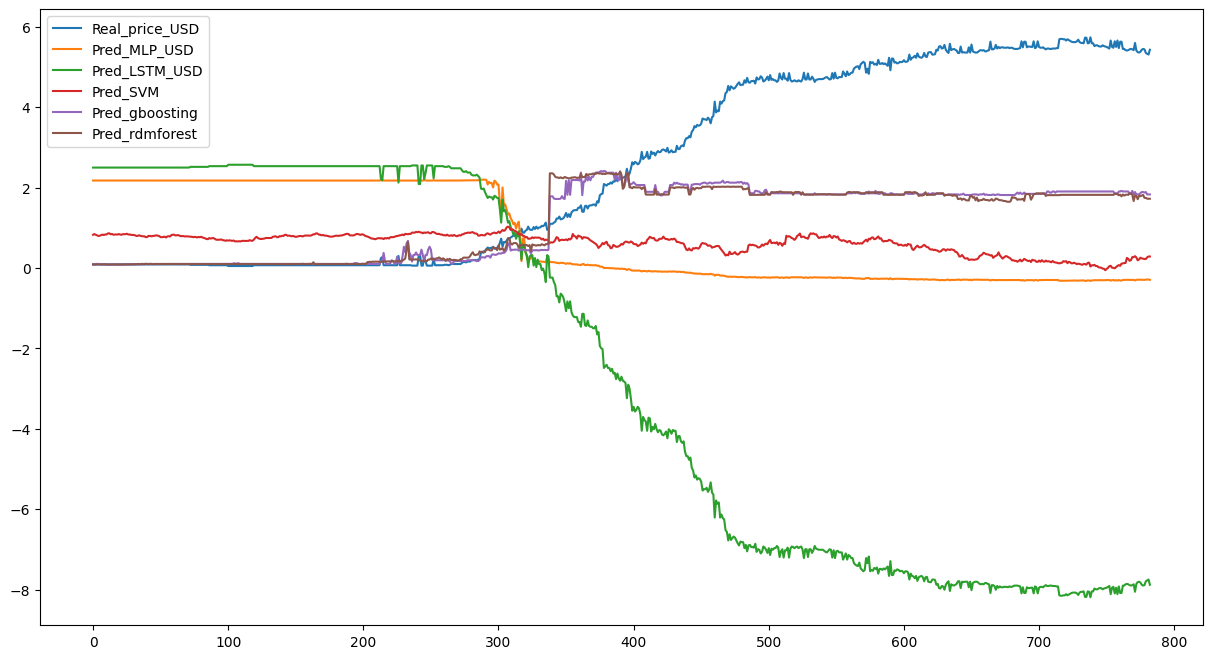

In [165]:
# Plot the consolidated forecasting results against the benchmark 3MUSD= index

results_USD_prediction['Real_price_USD'].plot(legend='Real level of USD3MD=', figsize=(15,8))
results_USD_prediction['Pred_MLP_USD'].plot(legend='Forecast MLP')
results_USD_prediction['Pred_LSTM_USD'].plot(legend='Forecast LSTM')
results_prediction_alternative['Pred_SVM'].plot(legend='Forecast SVM')
results_prediction_alternative['Pred_gboosting'].plot(legend='Forecast XGBoost')
results_prediction_alternative['Pred_rdmforest'].plot(legend='Forecast Random Forest')

In [166]:
# Computation of the mean absolut error (MAE):

MAE_pred_MLP_USD = mean_absolute_error(results_USD_prediction['Real_price_USD'], results_USD_prediction['Pred_MLP_USD'])
MAE_pred_LSTM_USD = mean_absolute_error(results_USD_prediction['Real_price_USD'], results_USD_prediction['Pred_LSTM_USD'])
MAE_pred_SVM_USD = mean_absolute_error(results_USD_prediction['Real_price_USD'], results_prediction_alternative['Pred_SVM'])
MAE_pred_gboosting_USD = mean_absolute_error(results_USD_prediction['Real_price_USD'], results_prediction_alternative['Pred_gboosting'])
MAE_pred_rdmforest_USD = mean_absolute_error(results_USD_prediction['Real_price_USD'], results_prediction_alternative['Pred_rdmforest'])

print("MAE obtained for the forecasted MLP model:", MAE_pred_MLP_USD)
print("MAE obtained for the forecasted LSTM model:", MAE_pred_LSTM_USD)
print("MAE obtained for the forecasted SVM model:", MAE_pred_SVM_USD)
print("MAE obtained for the forecasted Gradient Boosting model:", MAE_pred_gboosting_USD)
print("MAE obtained for the forecasted Random Forest model:", MAE_pred_rdmforest_USD)

# Computation of the mean squared error (MSE):

MSE_pred_MLP_USD = mean_squared_error(results_USD_prediction['Real_price_USD'], results_USD_prediction['Pred_MLP_USD'])
MSE_pred_LSTM_USD = mean_squared_error(results_USD_prediction['Real_price_USD'], results_USD_prediction['Pred_LSTM_USD'])
MSE_pred_SVM_USD = mean_squared_error(results_USD_prediction['Real_price_USD'], results_prediction_alternative['Pred_SVM'])
MSE_pred_gboosting_USD = mean_squared_error(results_USD_prediction['Real_price_USD'], results_prediction_alternative['Pred_gboosting'])
MSE_pred_rdmforest_USD = mean_squared_error(results_USD_prediction['Real_price_USD'], results_prediction_alternative['Pred_rdmforest'])

print("MSE obtained for the forecasted MLP model:", MSE_pred_MLP_USD)
print("MSE obtained for the forecasted LSTM model:", MSE_pred_LSTM_USD)
print("MSE obtained for the forecasted SVM model:", MSE_pred_SVM_USD)
print("MSE obtained for the forecasted Gradient Boosting model:", MSE_pred_gboosting_USD)
print("MSE obtained for the forecasted Random Forest model:", MSE_pred_rdmforest_USD)

# Computation of the root mean squared error (RMSE):

RMSE_pred_MLP_USD = np.sqrt(MSE_pred_MLP_USD)
RMSE_pred_LSTM_USD = np.sqrt(MSE_pred_LSTM_USD)
RMSE_pred_SVM_USD = np.sqrt(MSE_pred_SVM_USD)
RMSE_pred_gboosting_USD = np.sqrt(MSE_pred_gboosting_USD)
RMSE_pred_rdmforest_USD = np.sqrt(MSE_pred_rdmforest_USD)
print("RMSE obtained for the forecasted MLP model:", RMSE_pred_MLP_USD)
print("RMSE obtained for the forecasted LSTM model:", RMSE_pred_LSTM_USD)
print("RMSE obtained for the forecasted SVM model:", RMSE_pred_SVM_USD)
print("RMSE obtained for the forecasted Gradient Boosting model:", RMSE_pred_gboosting_USD)
print("RMSE obtained for the forecasted Random Forest model:", RMSE_pred_rdmforest_USD)

MAE obtained for the forecasted MLP model: 3.4431108652357856
MAE obtained for the forecasted LSTM model: 7.026710553815397
MAE obtained for the forecasted SVM model: 2.5054375685524346
MAE obtained for the forecasted Gradient Boosting model: 1.5175471813215036
MAE obtained for the forecasted Random Forest model: 1.5464991060025541
MSE obtained for the forecasted MLP model: 14.944550090765789
MSE obtained for the forecasted LSTM model: 74.54720650360798
MSE obtained for the forecasted SVM model: 10.198833469746992
MSE obtained for the forecasted Gradient Boosting model: 4.650260442609346
MSE obtained for the forecasted Random Forest model: 4.815069428556834
RMSE obtained for the forecasted MLP model: 3.865818165765921
RMSE obtained for the forecasted LSTM model: 8.634072417093105
RMSE obtained for the forecasted SVM model: 3.193561251917206
RMSE obtained for the forecasted Gradient Boosting model: 2.1564462531232595
RMSE obtained for the forecasted Random Forest model: 2.19432664582026